## This model includes all unique words

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.tokenize.casual import casual_tokenize



import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/breezehomefolder/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/breezehomefolder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Similarities between LOTR and HP:
- The ring bearer/ chosen one
- Gandalf the Grey/Albus Dumbledore
- Sauron the Deceiver and Lord Voldemort 
- The one ring/ Horcruxes
- Nazgul/ Dementors 
- Gollum/ The Elves 
- Shelob/ Aragog
- Mirror of Galadriel/ Mirror of Erised-Pensieve 
- Dead Marshes/ Inferi 
- The power of the ring/ Legilimens 

In [2]:
df = pd.read_csv('Data/reddit_corpus', index_col = 0)

In [4]:
df.fillna("", inplace = True)

I am going to make 2 models, one with the similarities between LOTR and HP, and one without... And see how the models perform! If a model has more difficulty identifying which reddit a particular text belongs to when characters are taken out, could that mean a similarity?

In [6]:
#only look at lotr subreddits
lotr_posts = df[df['subreddit'] == 'lotr']

In [7]:
#only look at harrypotter subreddits
hp_posts = df[df['subreddit'] == 'harrypotter']

In [8]:
df['subreddit'] = df['subreddit'].map({'harrypotter': 0, 'lotr': 1})

In [9]:
X = df['selftext']
y = df['subreddit']

In [10]:
# Check what we need to check in a classification problem.
y.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [11]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify = y)

In [12]:
vect = CountVectorizer()

In [13]:
vect.fit(X_train)
X_train = vect.transform(X_train)

In [14]:
X_train.shape

(3000, 5667)

In [15]:
vect.get_feature_names_out()

array(['000', '03', '10', ..., 'zombified', 'zone', 'zoom'], dtype=object)

In [16]:
vect2 = CountVectorizer()
vect2.fit(X_test)
X_test = vect2.transform(X_test)

In [17]:
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=vect.get_feature_names_out())

Plotting the top occuring words!

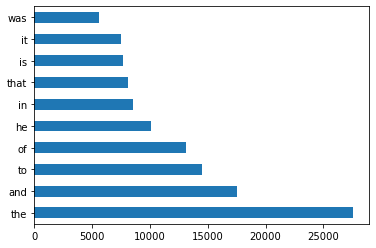

In [18]:
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');


In [19]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)


In [20]:
#Getting the baseline accuracy for my model
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [21]:
pipe = Pipeline([
    ('vect', CountVectorizer(binary = True, max_features = None)),
    ('model', LogisticRegression())
])


In [22]:
#How will my model perform on unseen data?
cross_val_score(pipe, X_train, y_train, cv=3).mean() 


0.9659999999999999

In [23]:
#From lecture on 2.25
param_grid = {
    'vect__binary': [True, False],
    'vect__max_features': [None, 4000, 5000],
    'vect__stop_words': ['english', None],
}
gs = GridSearchCV(pipe, param_grid=param_grid)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.966


{'vect__binary': True, 'vect__max_features': None, 'vect__stop_words': None}

/Users/breezehomefolder/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


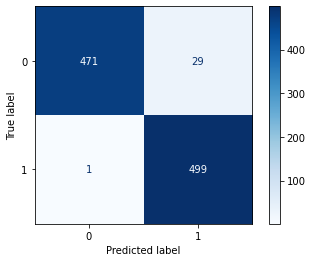

In [24]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');

Now let's use a Tfid

In [25]:
tvec = TfidfVectorizer()

In [26]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())


/Users/breezehomefolder/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)


In [28]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('model2', LinearRegression())
])

In [29]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}


In [30]:
#from lecture on 2.25
gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.


In [31]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('model2', LinearRegression())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [32]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.8901430192962474

In [33]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.8903517976118164

In [34]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

My Tfid performed less efficiently than my logistic regression.
Now let's do a Multinomial Naive Bayes Estimator and see how that performs!

In [78]:
from sklearn.naive_bayes import MultinomialNB

In [79]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])


In [80]:
cross_val_score(pipe, X_train, y_train, cv=3).mean() 


0.7506666666666667

In [81]:
# Fit your model
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [82]:
# Training score
pipe.score(X_train, y_train)

0.7516666666666667

In [83]:
# Test score
pipe.score(X_test, y_test)

0.712

The MNB Performed the worse of all models. My logistic regression did the best.
Actual No Predicted No (TN) = 471
Actual No Predicted Yes (FP) = 29
Actual Yes Predicted No (FN) = 1
Actual Yes Predicted Yes (TP) = 499

Now we will see how well the model will perform without unique keywords in them! I want to take out stop words, and re-run our model and see how it does!